# Hill Tononi Neuron and receptor-specific synapses

The Hill–Tononi (HT) neuron model is a multi-conductance integrate-and-fire–like formulation designed to capture a wide repertoire of cortical dynamics with biologically grounded ion-channel mechanisms. Unlike simpler point-neuron models that rely on a single synaptic variable, the HT neuron incorporates a set of receptor-specific synaptic conductances—AMPA, NMDA, GABA\_A, and GABA\_B—each with its own rise and decay kinetics, reversal potential, and maximal conductance. This structure allows the model to represent **realistic temporal integration** windows and receptor-dependent nonlinearities.

Receptor-specific synapses:
1)  Fast **AMPA** currents mediate rapid depolarization and determine the neuron’s response to high-frequency spikes;
2)  **NMDA** currents have a slower kinetics. They have **Voltage-dependent magnesium block**: at resting membrane potential, the channel pore is physically blocked by a magnesium ion (Mg²⁺). This prevents current from flowing even if glutamate binds. When the postsynaptic membrane depolarizes, the electrical repulsion pushes Mg²⁺ out of the pore, unblocking the channel and allowing Ca²⁺ and Na⁺ to enter. This introduce nonlinear summation and support sustained depolarization;
3) Inhibitory **GABA\_A** and slow **GABA\_B** currents shape both the instantaneous and prolonged components of inhibition, regulating gain control and stabilizing network activity.


In [1]:
import nest
import matplotlib.pyplot as plt


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.9.0
 Built: Oct  2 2025 07:08:06

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
nest.ResetKernel()
nest.GetDefaults("ht_neuron")["recordables"]

('g_AMPA',
 'g_GABA_A',
 'g_GABA_B',
 'g_NMDA',
 'I_h',
 'I_KNa',
 'I_NaP',
 'I_T',
 'theta',
 'V_m')

In [3]:
def simulate_ht_neuron(w_ampa, w_nmda,w_gaba_a,w_gaba_b, T=2000.):
    """
    Simulate a single Hill–Tononi (ht_neuron) cell with flexible activation of
    AMPA, NMDA, GABA_A, and GABA_B receptor-specific synapses.
    """
    nest.ResetKernel()
    ht_neuron = nest.Create('ht_neuron',1)
    spike_generator_1 = nest.Create("spike_generator", params={'spike_times': [300., 400., 500. ]})
    spike_generator_2 = nest.Create("spike_generator", params={'spike_times': [600., 700. ]})
    multimeter = nest.Create("multimeter", params={"record_from": ['V_m', 'g_AMPA', 'g_NMDA',  'g_GABA_A',  'g_GABA_B']})
    spike_recorder = nest.Create("spike_recorder")
    # if a neuron has AMPA & NMDA assume they are simultaneously activated
    nest.Connect(spike_generator_1, ht_neuron, syn_spec={'receptor_type':1, 'weight':w_ampa}) # AMPA receptor
    nest.Connect(spike_generator_1, ht_neuron, syn_spec={'receptor_type':2, 'weight':w_nmda}) # NMDA receptor
    # the same for GABA A and GABA B
    nest.Connect(spike_generator_2, ht_neuron, syn_spec={'receptor_type':3, 'weight':w_gaba_a}) # GABA_A receptor
    nest.Connect(spike_generator_2, ht_neuron, syn_spec={'receptor_type':4, 'weight':w_gaba_b}) # GABA_B receptor
    nest.Connect(ht_neuron, spike_recorder)
    nest.Connect(multimeter, ht_neuron)
    
    nest.Simulate(T)

    V_m = multimeter.get('events')['V_m']
    g_AMPA = multimeter.get('events')['g_AMPA']
    g_NMDA = multimeter.get('events')['g_NMDA']
    g_GABA_A = multimeter.get('events')['g_GABA_A']
    g_GABA_B = multimeter.get('events')['g_GABA_B']
    t = multimeter.get('events')['times']
    
    senders = spike_recorder.get('events')['senders']
    spike_train = spike_recorder.get('events')['times']

    return t, V_m, g_AMPA, g_NMDA,g_GABA_A, g_GABA_B, senders, spike_train

In [4]:
def plot_results(t, V_m, g_AMPA, g_NMDA,g_GABA_A, g_GABA_B, sender, spike_train):
    """
    Plot resulting dynamics. 
    """
    fig, axes = plt.subplots(6, 1, figsize=(6,10), sharex=True)
    
    # 1. Membrane potential
    axes[0].plot(t, V_m, color='black', linewidth=0.6)
    axes[0].set_ylabel("V_m (mV)")
    axes[0].set_title("Membrane Potential")
    
    # 2. AMPA conductance
    axes[1].plot(t, g_AMPA, color='red', linewidth=0.6)
    axes[1].set_ylabel("g_AMPA (nS)")
    axes[1].set_title("AMPA Conductance")
    
    # 3. NMDA conductance
    axes[2].plot(t, g_NMDA, color='purple', linewidth=0.6)
    axes[2].set_ylabel("g_NMDA (nS)")
    axes[2].set_title("NMDA Conductance")
    
    # 4. GABA_A conductance
    axes[3].plot(t, g_GABA_A, color='blue', linewidth=0.6)
    axes[3].set_ylabel("g_GABA_A (nS)")
    axes[3].set_title("GABA_A Conductance")
    
    # 5. GABA_B conductance
    axes[4].plot(t, g_GABA_B, color='green', linewidth=0.6)
    axes[4].set_ylabel("g_GABA_B (nS)")
    axes[4].set_title("GABA_B Conductance")
    
    # 6. Raster plot
    axes[5].scatter(spike_train, sender, s=100, marker='|', color='black')
    axes[5].set_ylabel("Neuron ID")
    axes[5].set_xlabel("Time (ms)")
    axes[5].set_title("Raster Plot")
    
    plt.tight_layout()
    plt.show()


Nov 05 01:46:12 NodeManager::prepare_nodes [Info]: 
    Preparing 5 nodes for simulation.

Nov 05 01:46:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 01:46:12 SimulationManager::run [Info]: 
    Simulation finished.


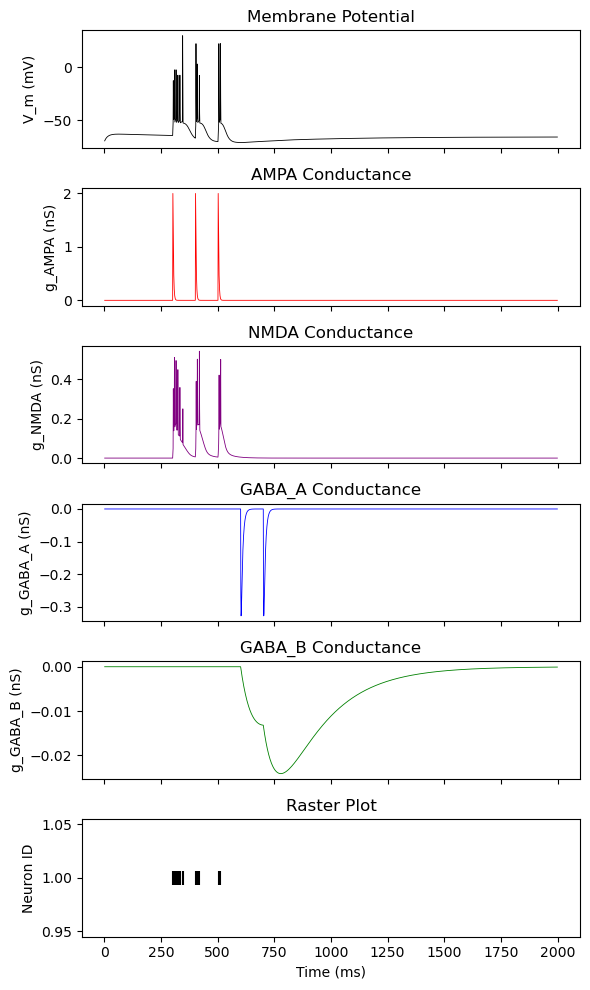

In [5]:
t, V_m, g_AMPA, g_NMDA,g_GABA_A, g_GABA_B,sender, spike_train = simulate_ht_neuron(20., 20., -1., -1.) # let's change the weights 
plot_results(t, V_m, g_AMPA, g_NMDA,g_GABA_A, g_GABA_B, sender, spike_train)

**Exercise:** try to provide in input Poisson generator at different frequencies on different receptors.

We use this model to illustrate the foundations of **parameter optimization** of neuronal models. In particular, the approach implemented here is a multi-objective optimization procedure designed to fit the parameters of a synapse model to experimental data.

In this example, the objective is to optimize the parameters of the AMPA synapse of a cerebellar granule cell using voltage-clamp recordings at –40 mV. The optimization algorithm searches the parameter space—such as peak conductance and kinetic time constants—so that the simulated synaptic current reproduces the experimental trace as closely as possible. 

The same framework is general and can be applied to many other parameter-fitting tasks. For example, one could use it to optimize neuronal membrane parameters to reproduce F–I curves measured with patch-clamp recordings, or to tune intrinsic conductances to match firing patterns observed in vitro.

Because the method is multi-objective and does not rely on a single error metric, it is especially powerful for capturing the rich, multidimensional structure of neural data and producing biologically realistic model parameters.

In [6]:
# Before continuing, install this package.
# !pip install pymoo

In [14]:
import numpy as np
import pandas as pd
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.termination.default import DefaultMultiObjectiveTermination


def single_sim(cell_params, sim_params, E_rev, duration):
    """
    It performs a single synaptic activation experiment on an ht_neuron in NEST. 
    It is designed to simulate how the synaptic conductance evolves over time when a single presynaptic spike is delivered.
    """
    syn_spec = {"weight": 1.0, "delay": 1, "receptor_type": sim_params["receptor_type"]}
    nest.ResetKernel()
    nest.resolution = 0.025

    cell = nest.Create("ht_neuron", 1, params=cell_params)
    input_spikes = nest.Create(
        "spike_generator", params={"spike_times": [sim_params["spike_time"]]}
    )
    nest.Connect(input_spikes, cell, syn_spec=dict(syn_spec, synapse_model="static_synapse"))

    multimeter = nest.Create(
        "multimeter",
        params={
            "interval": 0.025,
            "record_from": sim_params["record_from"],
            "record_to": "memory",
            "label": sim_params["label_multimeter"],
        },
    )
    spike_recorder = nest.Create(
        "spike_recorder",
        params={"record_to": "memory", "label": sim_params["label_spike_recorder"]},
    )
    nest.Connect(multimeter, cell)
    nest.Connect(cell, spike_recorder)
    nest.Simulate(duration)

    multimeter_data = multimeter.get()["events"]
    times = multimeter_data["times"]
    g_syn = multimeter_data[sim_params["current_name"]]
    return times, g_syn


def extract_trace(file_path, E_rev, v_clamp=-40.0, mg_block=None):
    """
    Extracts and converts a recorded current trace into a conductance trace.
    """
    df = pd.read_csv(file_path, delim_whitespace=True)
    df.columns = ["Time", "Current"]
    df["g"] = -df["Current"].values / (E_rev - v_clamp) * 1000
    if mg_block is not None:
        df["g"] = df["g"] / mg_block
    return df["Time"], df["g"]


def optimization(problem, xtol=1e-8, cvtol=1e-8, ftol=25e-4, period=30, n_gen=100, n_max_evals=10000):
    """
    Performs multi-objective optimization using the NSGA-II algorithm.
    """
    
    algorithm = NSGA2(pop_size=32) # number of evaluation per generation

    termination = DefaultMultiObjectiveTermination(
        xtol=xtol, cvtol=cvtol, ftol=ftol, period=period, n_max_gen=n_gen, n_max_evals=n_max_evals
    )
    results = minimize(problem, algorithm, termination, seed=1, verbose=True)
    return results


def compute_metrics(times, g_syn, trace_g, t_min=250, t_max=1000):
    """
    Computes error metrics between a synaptic conductance trace and a reference trace.
    The considered metrics are 
    1. Mean squared error between the conductance traces.
    2. peak_penalty : Relative difference between the peak values of the masked traces, used as a penalty for mismatch in peak amplitude.
    """
    mask_t = np.logical_and(times <= t_max, times > t_min)
    trace_g_masked = trace_g[mask_t]
    g_masked = g_syn[mask_t]
    mse_val = np.mean((trace_g_masked - g_masked) ** 2)
    peak_penalty = abs(np.max(trace_g_masked) - np.max(g_masked)) / np.max(trace_g_masked)
    return mse_val, peak_penalty

def select_solution(F, threshold=0.05):
    """
    Selects a solution from a set of 2D objective values based on a threshold.
    """
    mask = F[:, 1] <= threshold
    filtered = F[mask]
    idx_in_filtered = np.argmin(filtered[:, 0])
    idx = np.where(mask)[0][idx_in_filtered]
    return idx, F[idx]


def plot_pareto_front(res, sol_idx, threshold, title, save_path=None):
    mse_vals = res.F[:, 0]
    peak_penalty_vals = res.F[:, 1]
    plt.figure(figsize=(6, 4))
    plt.title(title)
    plt.scatter(mse_vals, peak_penalty_vals * 100, c="blue", alpha=0.5, edgecolors="none")
    plt.scatter(
        mse_vals[sol_idx],
        peak_penalty_vals[sol_idx] * 100,
        c="red",
        label="Selected solution",
        zorder=5,
        edgecolors="none",
    )
    plt.axhline(threshold, c="red", ls="--", alpha=0.5, label="Peak penalty threshold")
    plt.xlabel("MSE")
    plt.ylabel("Peak penalty (%)")
    plt.legend()
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()

def plot_conductance(
    params,
    sim_params,
    trace_file,
    E_rev,
    duration,
    optimized_params=None,
    title="Synaptic conductance",
    save_path=None,
    v_clamp=-40.0,
    mg_block=None,
    xlim=None,
):
    for key, val in optimized_params.items():
        params[key] = val

    times_sim, g_sim = single_sim(params, sim_params, E_rev, duration)
    trace_t, trace_g = extract_trace(trace_file, E_rev, v_clamp, mg_block)
    plt.figure(figsize=(8, 5))
    plt.title(title)
    plt.plot(times_sim, g_sim, label="NEST trace", color="black")
    plt.plot(trace_t, trace_g, label="TARGET trace", color="gray", linestyle="dashed")
    plt.xlabel("Time [ms]")
    plt.ylabel(r"$g_{syn}$ [ns]")
    plt.legend()
    if xlim is not None:
        plt.xlim(xlim)
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()

In [15]:
class SynapseOptimization(Problem):
    """
    Defines a multi-objective optimization problem for fitting synaptic parameters
    to a target conductance trace.
    """
    def __init__(
        self,
        cell_params,
        sim_params,
        trace_file,
        param_names,
        E_rev,
        tmin,
        tmax,
        v_clamp=-40.0,
        mg_block=None,
        duration=1001,
    ):
        self.cell_params = cell_params
        self.sim_params = sim_params
        self.trace_file = trace_file
        self.param_names = param_names
        self.E_rev = E_rev
        self.v_clamp = v_clamp
        self.duration = duration
        self.tmin = tmin
        self.tmax = tmax
        super().__init__(
            n_var=len(param_names),
            n_obj=2,
            n_constr=1,
            xl=np.array([0, 0, 0]),
            xu=np.array([5, 10.0, 10.]),
        )
        self.trace_t, self.trace_g = extract_trace(trace_file, E_rev, v_clamp, mg_block)

    def _evaluate(self, X, out, *args, **kwargs):
        f1 = []
        f2 = []
        for params in X:
            for name, value in zip(self.param_names, params):
                self.cell_params[name] = value
            times, g_syn = single_sim(
                self.cell_params, self.sim_params, self.E_rev, duration=self.duration
            )
            mse_val, peak_penalty = compute_metrics(
                times, g_syn, self.trace_g, self.tmin, self.tmax
            )
            f1.append(mse_val)
            f2.append(peak_penalty)
        out["F"] = np.column_stack([f1, f2])
        g = X[:, 1] - X[:, 2]
        out["G"] = g.reshape(-1, 1)

In [16]:
cell_params = {
    "E_rev_AMPA": 0.0,
}
sim_params = {
    "receptor_type": 1,
    "record_from": ["V_m", "g_AMPA"],
    "label_multimeter": "grc_multimeter",
    "label_spike_recorder": "grc_spike_recorder",
    "current_name": "g_AMPA",
    "spike_time": 250.0 - 31 * 0.025,
}
trace_file = "./data/AMPA_GrC.csv"
opt_param_names = [
    'g_peak_AMPA', # peak conductance
    'tau_rise_AMPA', # rise time
    'tau_decay_AMPA' # decay time, Tau_1 < Tau_2
]
problem = SynapseOptimization(
    cell_params,
    sim_params,
    trace_file,
    opt_param_names,
    E_rev=cell_params["E_rev_AMPA"],
    tmin=250,
    tmax=1000,
    duration=1001,
)
problem.xl = np.array([0, 0, 2])
problem.xu = np.array([5, 2.0, 10.])
res = optimization(problem, n_gen=20) # more gens if you want a better fit
sol_idx, solution = select_solution(res.F, threshold=0.01)
opt_params_dict = dict(zip(opt_param_names, res.X[sol_idx]))
os.makedirs("Optimized_params", exist_ok=True)
output_filename = "Optimized_params/params_AMPA_mf_Grc.txt"
save_params(opt_params_dict, output_filename)

/var/folders/ng/bmn1d9kx04v2yqrzjck6zhlw0000gn/T/ipykernel_97347/991233351.py:51: FutureWarning:The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



Nov 05 01:48:44 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.025 ms.

Nov 05 01:48:44 NodeManager::prepare_nodes [Info]: 
    Preparing 4 nodes for simulation.

Nov 05 01:48:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4
    Simulation time (ms): 1001
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 01:48:44 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 01:48:44 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.025 ms.

Nov 05 01:48:44 NodeManager::prepare_nodes [Info]: 
    Preparing 4 nodes for simulation.

Nov 05 01:48:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4
    Simulation time (ms): 1001
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 01:48:44 SimulationManager::run [Info]: 
    Simulation finished.

Nov 05 01:48:44 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.025 ms

NameError: name 'os' is not defined

**Pareto front**: The Pareto front is a fundamental concept in multi-objective optimization describing the set of non-dominated solutions in the objective space. In other words, a solution is called Pareto optimal if it is impossible to improve one objective without worsening at least one other objective.

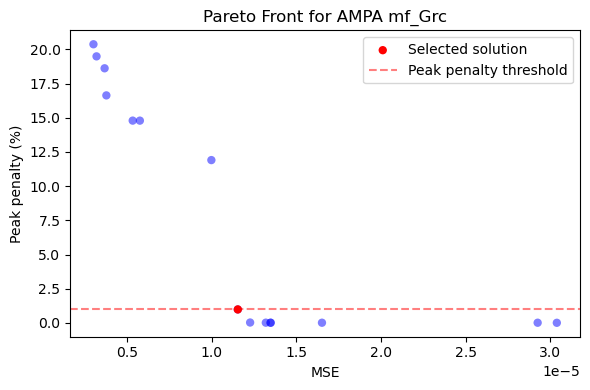

In [17]:
plot_pareto_front(
    res,
    sol_idx,
    threshold=1,
    title="Pareto Front for AMPA mf_Grc",
    save_path="./Pareto_AMPA_mf_GrC.png",
)
sim_params["record_from"] = ["V_m", "g_AMPA"]


Nov 05 01:55:06 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.025 ms.

Nov 05 01:55:06 NodeManager::prepare_nodes [Info]: 
    Preparing 4 nodes for simulation.

Nov 05 01:55:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4
    Simulation time (ms): 1001
    Number of OpenMP threads: 1
    Not using MPI

Nov 05 01:55:06 SimulationManager::run [Info]: 
    Simulation finished.


/var/folders/ng/bmn1d9kx04v2yqrzjck6zhlw0000gn/T/ipykernel_97347/991233351.py:51: FutureWarning:The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead


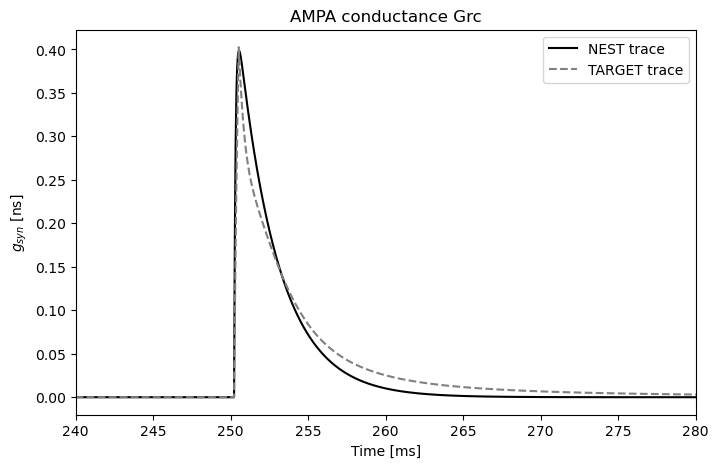

In [20]:
plot_conductance(
    params=cell_params,
    sim_params=sim_params,
    trace_file=trace_file,
    E_rev=cell_params["E_rev_AMPA"],
    optimized_params=opt_params_dict,
    title="AMPA conductance Grc",
    xlim=(240, 280),
    save_path="./opt_AMPA_mf_GrC.png",
    duration=1001,
)

In [19]:
print("Selected solution parameters:")
print(res.X[sol_idx])

Selected solution parameters:
[0.39856221 0.09323973 2.54888411]


**Exercise:** try to optimize granule cell's NMDA conductance starting from ./data/NMDA_GrC.csv